I provide two ways of modeling seasonal effect. For effects that take less values (e.g. weekly effects), we can assign a state value to each day. For effects that have a longer cycle (e.g. quarterly effects), we may model them using trigonmetric cycles.


In [1]:
"""
Cyclical model
"""
import numpy as np
import pandas as pd
import linkalman
import scipy
from linkalman.models import BaseConstantModel as BCM
from linkalman.core.utils import Constant_M
from scipy.optimize import minimize
import matplotlib.pyplot as plt
%matplotlib inline 



/usr/local/Cellar/python/3.7.2_2/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


# Initialization
A cyclical model can be written as:

$\begin{pmatrix}\phi_t \\\phi_t^{*}\end{pmatrix} = \rho 
\begin{pmatrix}cos\lambda & sin\lambda \\-sin\lambda & cos\lambda 
\end{pmatrix}\begin{pmatrix}\phi_{t-1} \\ \phi_{t-1}^{*}\end{pmatrix} 
+ \begin{pmatrix}\omega_{t-1} \\ \omega_{t-1}^{*}\end{pmatrix}$

$y_t = \phi_t + \varepsilon_t$

$\lambda$ determines the cycle frequency, and $\rho$ is the dampening factor. If $\rho=1$, the process is non-stationary. 

In [2]:
def my_f(theta):
    # Generate F
    lambda_ = np.pi / (1 + np.exp(theta[0]))  
    rho = 1 / (1 + np.exp(theta[3]))
    sigQ = np.exp(theta[1])
    sigR = np.exp(theta[2])
    F = rho * np.array([[np.cos(lambda_), np.sin(lambda_)], [-np.sin(lambda_), np.cos(lambda_)]])
    # Generate Q
    Q = np.array([[sigQ, 0], [0, sigQ]]) 
    R = np.array([[sigR]])
    # Generate H
    H = np.array([[1, 0]])
    # Collect system matrices
    M = {'F': F, 'Q': Q, 'H': H, 'R': R}

    return M


In [3]:
def my_solver(param, obj_func, verbose=False, **kwargs):
    """
    Simple solver for LLY
    """
    obj_ = lambda x: -obj_func(x)
    def disp_f(x):
        print('theta is {}. Function value is: {}.'.format(x, obj_func(x)))
    callbackf = None
    if verbose:
        callbackf = disp_f
    res = minimize(obj_, param, callback=callbackf, **kwargs)
    theta_opt = np.array(res.x)
    fval_opt = res.fun
    return theta_opt, fval_opt

In [4]:
# Initialize the model
x = 1  
model = BCM()
model.set_f(my_f, is_warning=False)
model.set_solver(my_solver, method='nelder-mead', 
        options={'xatol': 1e-7, 'disp': True, 'maxiter': 10000}, verbose=True) 

# Generate Synthetic Data

In [5]:
# Some initial parameters
theta = np.array([2, -0.1, 0.2, -3])  
T = 365
train_split_ratio = 0.7
forecast_cutoff_ratio = 0.8  
missing_range = [0.3, 0.5]

# Split train data
train_split_t = np.floor(T * train_split_ratio).astype(int)

# Generate missing data for forcasting
forecast_t = np.floor(T * forecast_cutoff_ratio).astype(int)

x_col = ['const']
Xt = pd.DataFrame({x_col[0]: x * np.ones(T)})  

# Build simulated data
df, y_col, xi_col = model.simulated_data(input_theta=theta, Xt=Xt)

# Store fully visible y for comparison later
df['y_0_vis'] = df.y_0.copy()  

# Insert some missingness
missing_start_t = np.floor(T * missing_range[0]).astype(int)
missing_end_t = np.floor(T * missing_range[1]).astype(int)
is_missing = (df.index >= missing_start_t) & (df.index < missing_end_t)
df.loc[is_missing, ['y_0']] = np.nan

# Splits models into three groups
is_train = df.index < train_split_t
is_test = (~is_train) & (df.index < forecast_t)
is_forecast = ~(is_train | is_test)

# Create a training and test data
df_train = df.loc[is_train].copy()

# Build two kinds of test data (full data vs. test data only)
df_test = df.copy()  
df_test_only = df.loc[is_test | is_forecast].copy()  

# Create an offset
df_test.loc[is_forecast, ['y_0']] = np.nan
df_test_only.loc[df_test_only.index >= forecast_t, ['y_0']] = np.nan

# Fit and Predict

In [6]:
# Fit data using LLY:
theta_init = np.random.rand(len(theta))
model.fit(df_train, theta_init, y_col=y_col, x_col=x_col, 
              method='LLY')

# Make predictions from LLY:
df_LLY = model.predict(df_test)
df_LLY['kf_ub'] = df_LLY.y_0_filtered + 1.96 * np.sqrt(df_LLY.y_0_fvar)
df_LLY['kf_lb'] = df_LLY.y_0_filtered - 1.96 * np.sqrt(df_LLY.y_0_fvar)
df_LLY['ks_ub'] = df_LLY.y_0_smoothed + 1.96 * np.sqrt(df_LLY.y_0_svar)
df_LLY['ks_lb'] = df_LLY.y_0_smoothed - 1.96 * np.sqrt(df_LLY.y_0_svar)

# Make predictions using true theta:
df_true = model.predict(df_test, theta=theta)
df_true['kf_ub'] = df_true.y_0_filtered + 1.96 * np.sqrt(df_true.y_0_fvar)
df_true['kf_lb'] = df_true.y_0_filtered - 1.96 * np.sqrt(df_true.y_0_fvar)
df_true['ks_ub'] = df_true.y_0_smoothed + 1.96 * np.sqrt(df_true.y_0_svar)
df_true['ks_lb'] = df_true.y_0_smoothed - 1.96 * np.sqrt(df_true.y_0_svar)

theta is [0.09562186 0.77448903 0.03796528 0.59428589]. Function value is: -762.5156324009477.
theta is [0.09562186 0.77448903 0.03796528 0.59428589]. Function value is: -762.5156324009477.
theta is [0.10368995 0.79984432 0.03760935 0.56271445]. Function value is: -755.960674867033.
theta is [0.09659302 0.84652112 0.03734241 0.59846446]. Function value is: -745.7413917858025.
theta is [0.09659302 0.84652112 0.03734241 0.59846446]. Function value is: -745.7413917858025.
theta is [0.09817115 0.91286267 0.0384658  0.51611176]. Function value is: -732.8256788426472.
theta is [0.10725476 0.99820269 0.03599379 0.5020526 ]. Function value is: -714.5255682560246.
theta is [0.10725476 0.99820269 0.03599379 0.5020526 ]. Function value is: -714.5255682560246.
theta is [0.10024508 1.14225561 0.03937102 0.45924944]. Function value is: -690.3025652272944.
theta is [0.10888579 1.34504001 0.03783746 0.31165958]. Function value is: -663.4104280937656.
theta is [0.1137655  1.53648991 0.03511943 0.323025

theta is [ 1.9355448   0.54015292 -0.70371308 -2.88220354]. Function value is: -401.38735417429916.
theta is [ 1.9355448   0.54015292 -0.70371308 -2.88220354]. Function value is: -401.38735417429916.
theta is [ 1.92446858  0.7020487  -0.69894558 -1.92365609]. Function value is: -399.4483437163215.
theta is [ 1.92446858  0.7020487  -0.69894558 -1.92365609]. Function value is: -399.4483437163215.
theta is [ 1.92446858  0.7020487  -0.69894558 -1.92365609]. Function value is: -399.4483437163215.
theta is [ 1.83874578  0.66093203 -0.66499187 -2.24199932]. Function value is: -399.02464183067366.
theta is [ 1.83874578  0.66093203 -0.66499187 -2.24199932]. Function value is: -399.02464183067366.
theta is [ 1.94743145  0.55947576 -0.7090156  -2.16425759]. Function value is: -397.9698273379134.
theta is [ 1.94743145  0.55947576 -0.7090156  -2.16425759]. Function value is: -397.9698273379134.
theta is [ 1.94743145  0.55947576 -0.7090156  -2.16425759]. Function value is: -397.9698273379134.
theta 

theta is [ 1.85326521  0.16024683 -0.40343006 -2.60141497]. Function value is: -395.21404023816797.
theta is [ 1.8736086   0.15601318 -0.32821618 -2.65697322]. Function value is: -393.9595950095509.
theta is [ 1.8736086   0.15601318 -0.32821618 -2.65697322]. Function value is: -393.9595950095509.
theta is [ 1.83941286 -0.07030826 -0.12092625 -2.88001529]. Function value is: -393.2534043249796.
theta is [ 1.83941286 -0.07030826 -0.12092625 -2.88001529]. Function value is: -393.2534043249796.
theta is [ 1.85192213 -0.13624535 -0.01158506 -2.96761118]. Function value is: -392.33391498181317.
theta is [ 1.85192213 -0.13624535 -0.01158506 -2.96761118]. Function value is: -392.33391498181317.
theta is [ 1.85192213 -0.13624535 -0.01158506 -2.96761118]. Function value is: -392.33391498181317.
theta is [ 1.86460362e+00  1.69128350e-03 -6.22504122e-02 -2.88377041e+00]. Function value is: -391.9925951010993.
theta is [ 1.89054742 -0.13766844  0.08114686 -3.08483067]. Function value is: -391.68777

theta is [ 1.88944629 -0.06962968  0.07719393 -2.84731901]. Function value is: -391.36808909663876.
theta is [ 1.88942743 -0.06952699  0.07713401 -2.84715855]. Function value is: -391.3680890433996.
theta is [ 1.88942743 -0.06952699  0.07713401 -2.84715855]. Function value is: -391.3680890433996.
theta is [ 1.88942743 -0.06952699  0.07713401 -2.84715855]. Function value is: -391.3680890433996.
theta is [ 1.88942743 -0.06952699  0.07713401 -2.84715855]. Function value is: -391.3680890433996.
theta is [ 1.88942743 -0.06952699  0.07713401 -2.84715855]. Function value is: -391.3680890433996.
theta is [ 1.88944722 -0.06955942  0.07712651 -2.84724636]. Function value is: -391.36808900231983.
theta is [ 1.88943956 -0.06959488  0.07716156 -2.84728549]. Function value is: -391.3680889964998.
theta is [ 1.88943079 -0.06957566  0.0771251  -2.84725361]. Function value is: -391.36808898847096.
theta is [ 1.88943388 -0.06956409  0.07714274 -2.84729689]. Function value is: -391.3680889807545.
theta i

# Check Model Performance

In [7]:
def simple_plot(df, col_est, col_actual, col_ub, col_lb, label_est,
                label_actual, title, figsize=(20, 10)):
    ax = plt.figure(figsize=figsize)
    plt.plot(df.index, df[col_est], 'r', label=label_est)
    plt.scatter(df_LLY.index, df[col_actual], s=20, c='b', 
                marker='o', label=label_actual)
    plt.fill_between(df.index, df[col_ub], df[col_lb], color='g', alpha=0.2)
    ax.legend(loc='right', fontsize=12)
    plt.title(title, fontsize=22)
    plt.show()

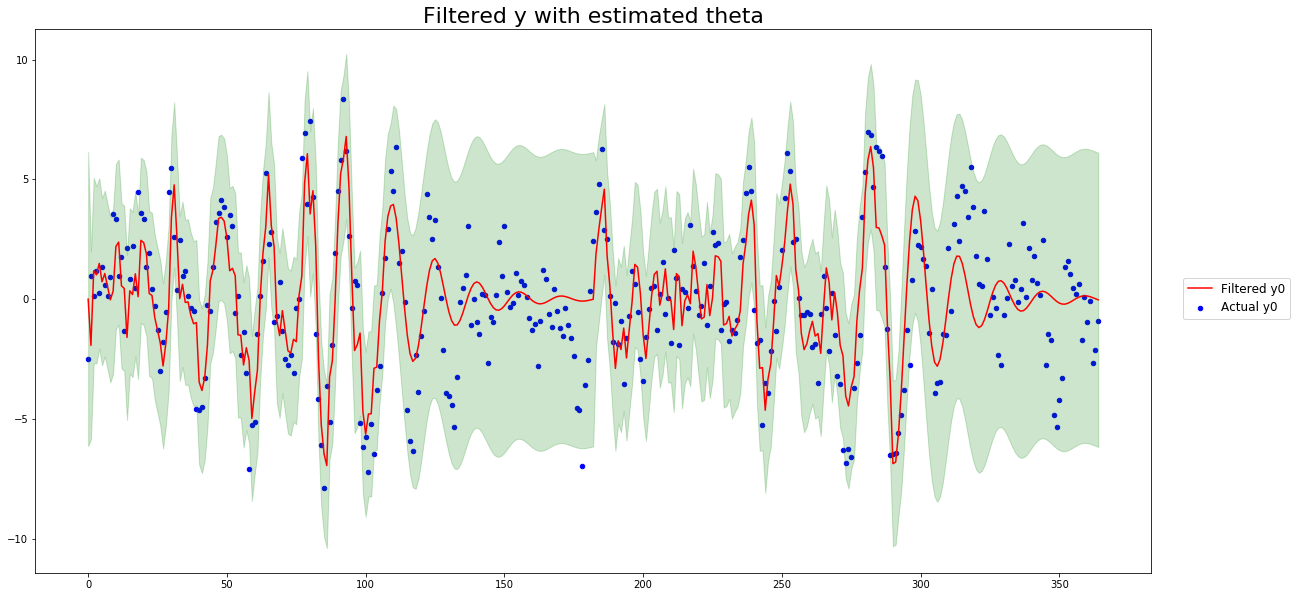

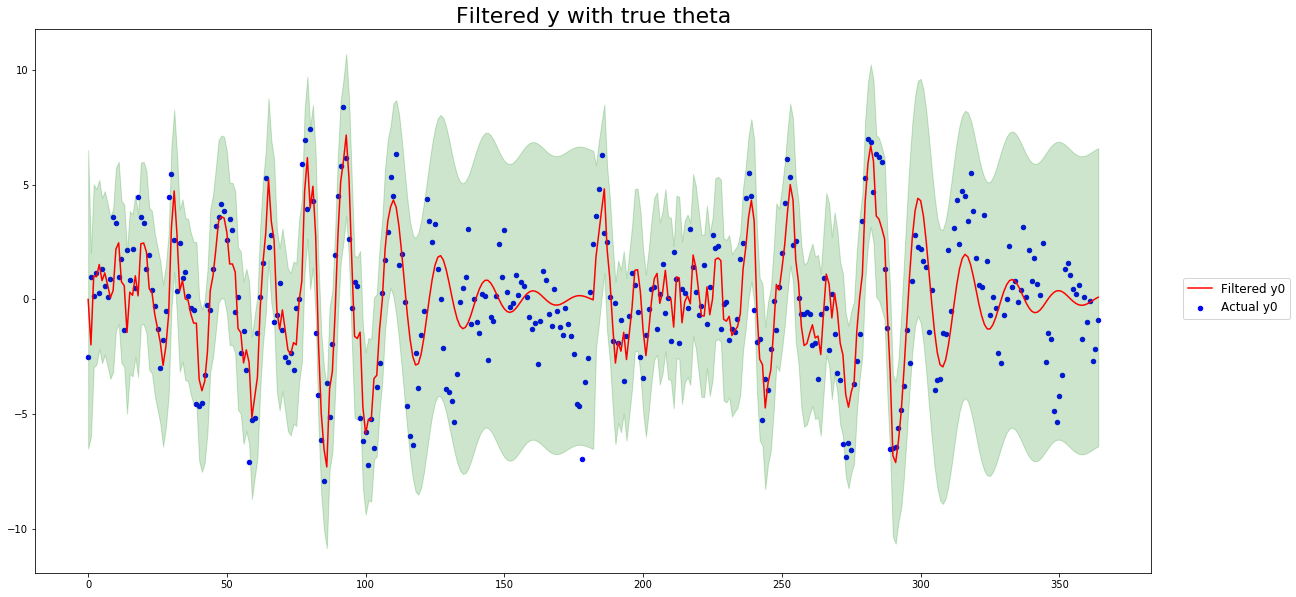

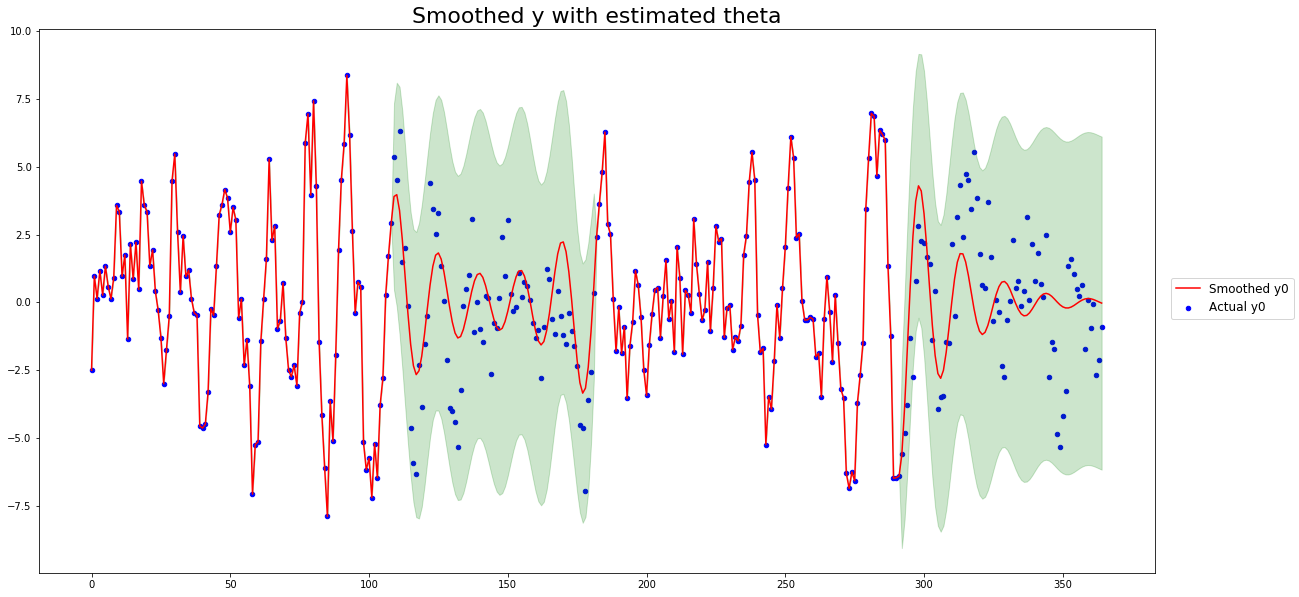

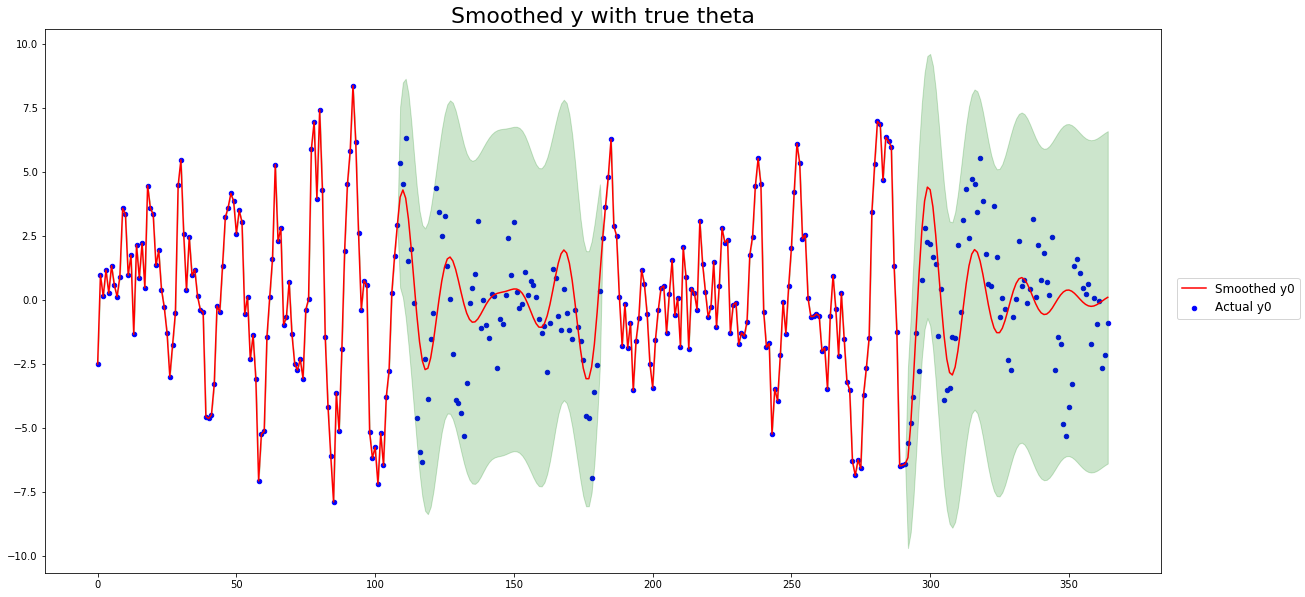

In [8]:
simple_plot(df_LLY, 'y_0_filtered', 'y_0_vis', 'kf_ub', 'kf_lb', 'Filtered y0', 'Actual y0',
           'Filtered y with estimated theta')
simple_plot(df_true, 'y_0_filtered', 'y_0_vis', 'kf_ub', 'kf_lb', 'Filtered y0', 'Actual y0',
           'Filtered y with true theta')
simple_plot(df_LLY, 'y_0_smoothed', 'y_0_vis', 'ks_ub', 'ks_lb', 'Smoothed y0', 'Actual y0',
           'Smoothed y with estimated theta')
simple_plot(df_true, 'y_0_smoothed', 'y_0_vis', 'ks_ub', 'ks_lb', 'Smoothed y0', 'Actual y0',
           'Smoothed y with true theta')

In [9]:
# Build a simple function
def summary_stats(df, col_est, col_true):
    RMSE = np.sqrt((df[col_est] - df[col_true]).var())
    mean_error = (df[col_est] - df[col_true]).mean()
    return {'RMSE': RMSE, 'mean_error': mean_error}

In [10]:
# Compare model performance in training data
print('LLY theta for training data: {}'.format(
    summary_stats(df_LLY[is_train], 'y_0_filtered', 'y_0_vis')))
print('Ture theta for training data: {}'.format(
    summary_stats(df_true[is_train], 'y_0_filtered', 'y_0_vis')))

LLY theta for training data: {'RMSE': 1.8935360713194334, 'mean_error': 0.10600435492649572}
Ture theta for training data: {'RMSE': 2.0142696796925845, 'mean_error': 0.11588007575064672}


In [11]:
# Compare model performance in test data
print('LLY theta for test data: {}'.format(
    summary_stats(df_LLY[is_test], 'y_0_filtered', 'y_0_vis')))
print('Ture theta for test data: {}'.format(
    summary_stats(df_true[is_test], 'y_0_filtered', 'y_0_vis')))

LLY theta for test data: {'RMSE': 1.9196782878275802, 'mean_error': 0.2693362910412902}
Ture theta for test data: {'RMSE': 1.817130423968833, 'mean_error': 0.3007451997864001}


In [12]:
# Compare model performance in forecast data
print('LLY theta for forecast data: {}'.format(
    summary_stats(df_LLY[is_forecast], 'y_0_filtered', 'y_0_vis')))
print('Ture theta for forecast data: {}'.format(
    summary_stats(df_true[is_forecast], 'y_0_filtered', 'y_0_vis')))

LLY theta for forecast data: {'RMSE': 2.2983617610949856, 'mean_error': -0.002618555472410943}
Ture theta for forecast data: {'RMSE': 2.210141960418383, 'mean_error': -0.04265210851666409}
